In [23]:
from solver import Solver
from model import Net, NetConnected, NetConnected100
from model_nomatrix import NetNomatrix
from model_nomatrix3 import NetNomatrix16, NetNomatrix16V2
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from experiment import get_data_loader
from lossfn import *

In [2]:
def plot_train_loss(dim, paths, logscale=True, labels=[], includeTest=False, model_class=Net, legendTitle=None, filename=None):
    fig = plt.figure(figsize=(13,7))
    if len(labels) == 0:
        labels = [''] * len(paths)
    for path, label in zip(paths, labels):
        # Plot train loss
        model = model_class(dim)
        solver = Solver(model)
        solver.load_checkpoint(path)
        for key in solver.hist["individual_train_losses"]:
            plt.plot(solver.hist["iterations"][1:], solver.hist["individual_train_losses"][key][1:], label=label+' '+("MSE" if key == "mse" else ("Norm loss" if key == "norm" else key.capitalize())))
        if includeTest:
            plt.plot(solver.hist["iterations"][1:], solver.hist["test_loss"][1:], label=label+' Test MSE')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.ylabel("Loss value")
    plt.xlabel("Iteration")
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

In [3]:
def plot_test_loss(dim, train_range, keys, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, legendTitle=None, filename=None):
    fig = plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            filepath = get_path(key, n_train)
            if os.path.exists(filepath):
                ntrains.append(n_train)
                solver.load_checkpoint(filepath)
                test_loss.append(solver.hist["test_loss"][-1])
                if includeNormed:
                    solver.fn_pred = fn_pred_normed
                    test_loss_normed.append(solver.test(test_loader, prints=False))
        plt.plot(ntrains, test_loss, label=key)
        if includeNormed:
            plt.plot(ntrains, test_loss_normed, label=str(key)+'_testnormed')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.ylabel("Test MSE loss")
    plt.xlabel("Number of training data points")
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

In [34]:
def plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, percentiles=False, max_iteration=float("inf"), model_class=lambda key: Net, legendTitle=None, filename=None, label=lambda key: key):
    fig = plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            test_loss_n_train = []
            test_loss_normed_n_train = []
            ntrains.append(n_train)
            for stat_val in stat_range:
                model = model_class(key)(dim)
                solver = Solver(model)
                filepath = get_path(key, n_train, stat_val)
                if os.path.exists(filepath):
                    solver.load_checkpoint(filepath)
                    test_index = len(solver.hist["test_loss"]) - 1
                    while (solver.hist["iterations"][test_index] > max_iteration):
                        test_index -= 1
                    test_loss_n_train.append(solver.hist["test_loss"][test_index])
                    if includeNormed:
                        solver.fn_pred = fn_pred_normed
                        test_loss_normed_n_train.append(solver.test(test_loader, prints=False))
                else:
                    print('Missing filepath:')
                    print(filepath)
            test_loss.append(test_loss_n_train)
            test_loss_normed.append(test_loss_normed_n_train)
        test_loss = np.array(test_loss)
        test_loss_normed = np.array(test_loss_normed)
        if len(test_loss):
            if percentiles:
                p = plt.plot(ntrains, np.median(test_loss, axis=1), label=label(key))
                #color = p[0].get_color()
                #plt.plot(ntrains, np.percentile(test_loss, 80, axis=1), linestyle='--', color=color, linewidth=0.5)
                #plt.plot(ntrains, np.percentile(test_loss, 20, axis=1), linestyle='--', color=color, linewidth=0.5)
            else: 
                p = plt.plot(ntrains, test_loss.mean(axis=1), label=label(key), linestyle='--', marker='o')
                # plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=label(key))
        if includeNormed:
            plt.errorbar(ntrains, test_loss_normed.mean(axis=1), yerr=test_loss_normed.std(axis=1), capsize=5, markeredgewidth=2, label=str(key)+'_testnormed')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    plt.xlabel("Train dataset size $N_{train}$")
    plt.ylabel("Test MSE loss")
    if logscale:
        plt.yscale('log')
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

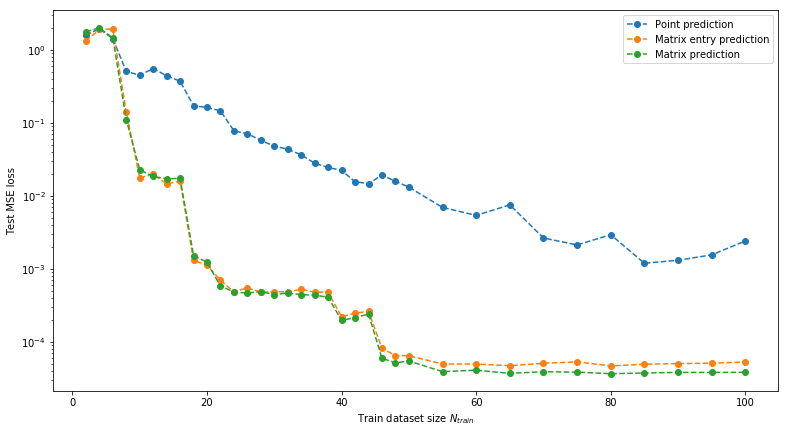

In [38]:
# Plot to compare all models
dim = 2
train_range = list(range(2, 50, 2)) + list(range(50, 101, 5))
keys = list(range(3))
n_runs = 1
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    if key == 0:
        checkpoint_dir += 'round2_normweight_model3_V2_range2/'
        checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, train_seed)
    elif key == 1:
        checkpoint_dir += 'round2_detweight_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, train_seed)
    elif key == 2:
        checkpoint_dir += 'round2_detweight_model2_100_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'


plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:[NetNomatrix16V2, Net, NetConnected100][key], label=lambda key:["Point prediction", "Matrix entry prediction", "Matrix prediction"][key])

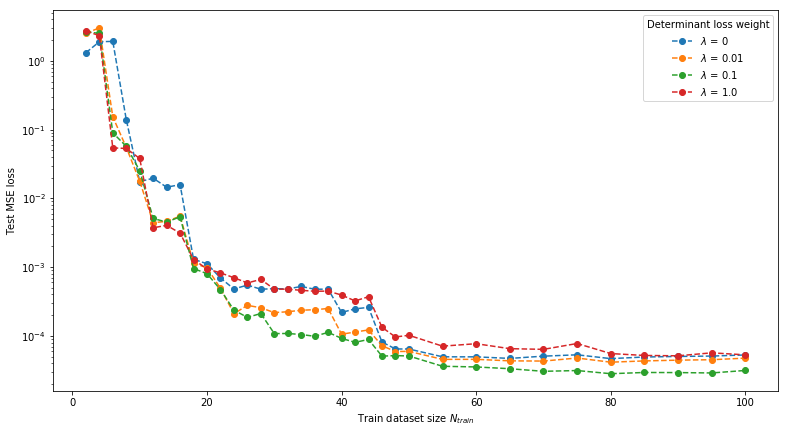

In [49]:
# Plot of det loss for wide range - matrix entry model
dim = 2
train_range = list(range(2, 50, 2)) + list(range(50, 101, 5))
keys = [0, 1e-2, 1e-1, 1e0]
n_runs = 1
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight_range2/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:Net, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

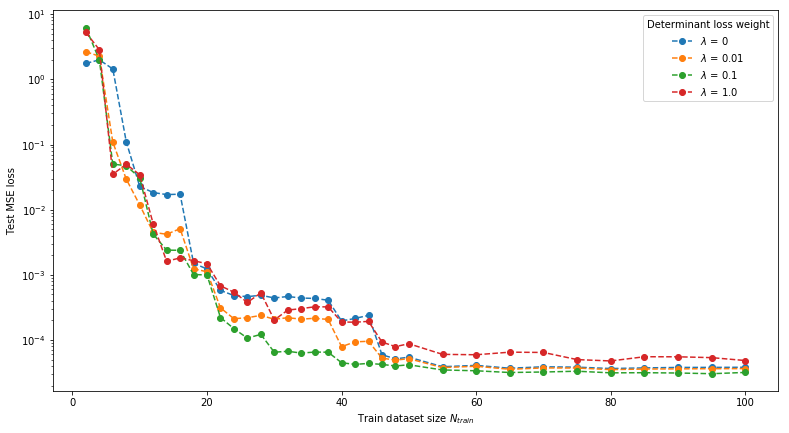

In [51]:
# Plot of det loss for wide range - matrix model
dim = 2
train_range = list(range(2, 50, 2)) + list(range(50, 101, 5))
keys = [0, 1e-2, 1e-1, 1e0]
n_runs = 1
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight_model2_100_range2/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:NetConnected100, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

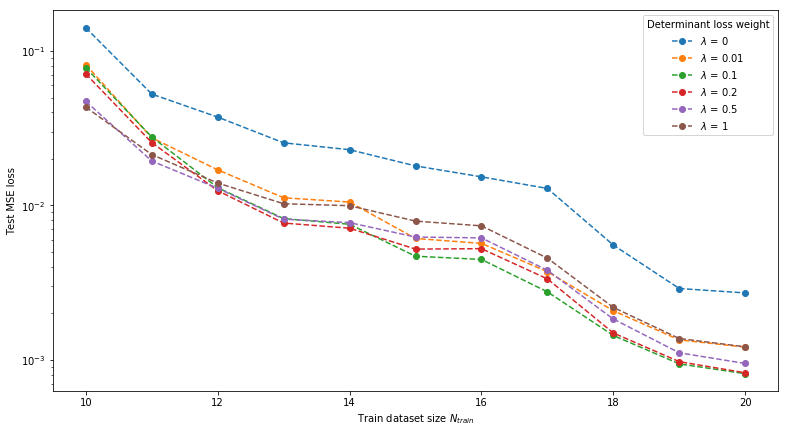

In [57]:
# Plot for det loss for small range - matrix entry model
dim = 2
train_range = list(range(10, 21, 1))
# keys = [0, 1e-2, 1e-1, 1e0]
keys = [0, 1e-2, 0.1, 0.2, 0.5, 1]
# det_weights = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    # checkpoint_dir += 'round2_detweight_range2/'
    checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:Net, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

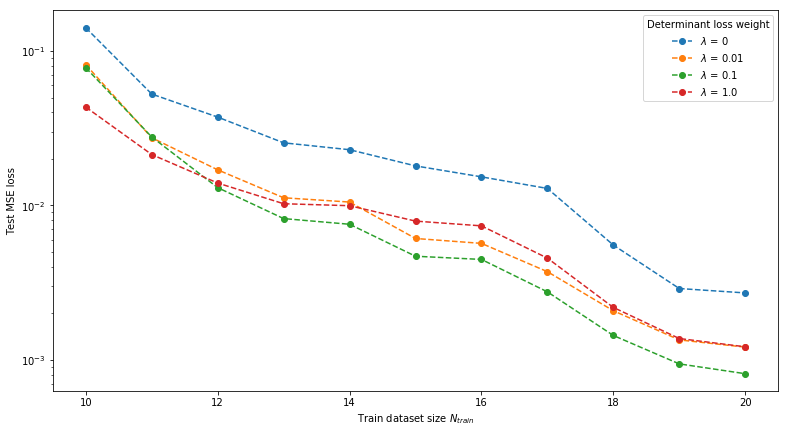

In [55]:
# Plot for det loss for small range - matrix model
dim = 2
train_range = list(range(10, 21, 1))
keys = [0, 1e-2, 1e-1, 1e0]
# det_weights = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight_range2/'
    # checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:Net, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

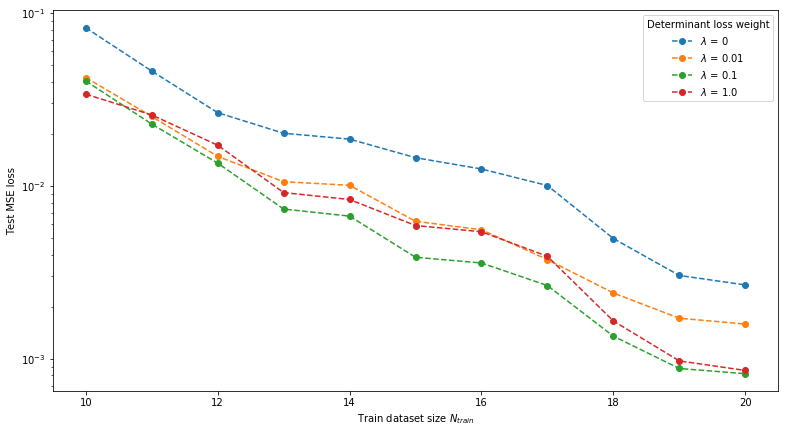

In [53]:
# Plot for det loss for small range
dim = 2
train_range = list(range(10, 21, 1))
keys = [0, 1e-2, 1e-1, 1e0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight_model2_100_range2/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:NetConnected100, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

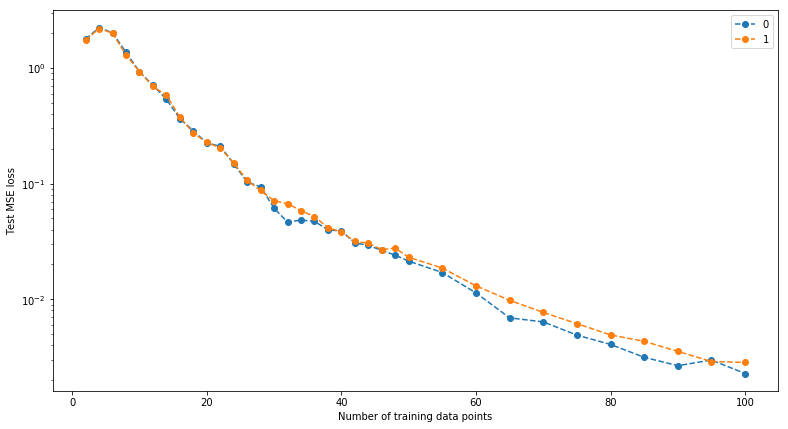

In [22]:
dim = 2
train_range = list(range(2, 50, 2)) + list(range(50, 101, 5))
keys = [0, 1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(norm_weight, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight_model3_V2_range2/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, norm_weight, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda _:NetNomatrix16V2)
